# 🚀 Building NanoGPT: A Complete Transformer from Scratch

## What You'll Learn
- **Build a real GPT**: From the "Attention is All You Need" paper
- **Multi-Head Attention**: Why 8 heads are better than 1
- **Residual Connections**: The secret to training deep networks
- **Train on Shakespeare**: Generate text in Elizabethan English

## Architecture Overview

```
Input Text
    ↓
Token + Position Embeddings
    ↓
[Transformer Block] × N layers
│   ├─ Multi-Head Attention (with causal mask)
│   ├─ Residual Connection + LayerNorm
│   ├─ Feed-Forward Network
│   └─ Residual Connection + LayerNorm
    ↓
Output Head (predict next token)
```

This is the **Decoder-Only** architecture used by GPT-3, GPT-4, Llama, and Claude.

---

In [1]:
# Setup and Imports
import sys
import math
import numpy as np
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import matplotlib.pyplot as plt

# Import our utilities
from mlx_nlp_utils import print_device_info, load_sample_corpus, create_char_vocab

print_device_info()


🖥️  Hardware Acceleration Check:
   Device: Device(gpu, 0)
   ✅ Using Apple Silicon GPU (Metal)
   ℹ️  MLX automatically optimizes for the GPU's Unified Memory.
   ℹ️  Note: While Apple Silicon has an NPU (Neural Engine), MLX primarily
       uses the powerful GPU for general-purpose training tasks like LSTMs.


## 1. Multi-Head Attention

Instead of one attention head, we split the embedding into $h$ heads, compute attention for each, and concatenate the results.

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, n_embd, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        
        # Key, Query, Value projections combined
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def __call__(self, x, mask=None):
        B, T, C = x.shape
        
        # Calculate Q, K, V
        qkv = self.c_attn(x)
        q, k, v = mx.split(qkv, 3, axis=-1)
        
        # Reshape for multi-head: (B, T, n_head, head_dim) -> (B, n_head, T, head_dim)
        q = q.reshape(B, T, self.n_head, self.head_dim).transpose(0, 2, 1, 3)
        k = k.reshape(B, T, self.n_head, self.head_dim).transpose(0, 2, 1, 3)
        v = v.reshape(B, T, self.n_head, self.head_dim).transpose(0, 2, 1, 3)
        
        # Scaled Dot-Product Attention
        scale = 1.0 / math.sqrt(self.head_dim)
        scores = (q @ k.transpose(0, 1, 3, 2)) * scale
        
        if mask is not None:
            scores = scores + mask
            
        attn = mx.softmax(scores, axis=-1)
        attn = self.attn_dropout(attn)
        
        # Weighted sum
        y = (attn @ v)
        
        # Reassemble heads: (B, n_head, T, head_dim) -> (B, T, C)
        y = y.transpose(0, 2, 1, 3).reshape(B, T, C)
        
        return self.resid_dropout(self.c_proj(y))

## 2. Feed-Forward Network

A simple MLP applied to each position independently.

In [3]:
class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def __call__(self, x):
        return self.net(x)

## 3. The Transformer Block

Combining Attention and Feed-Forward with Residuals and Normalization.

In [4]:
class Block(nn.Module):
    def __init__(self, n_head, n_embd, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_head, n_embd, dropout)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd, dropout)

    def __call__(self, x, mask=None):
        # Residual connections: x + layer(norm(x))
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return x

## 4. The GPT Model

Putting it all together: Embeddings -> Blocks -> Output Head.

In [5]:
class GPT(nn.Module):
    def __init__(self, vocab_size, n_layer, n_head, n_embd, block_size, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[
            Block(n_head, n_embd, dropout) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def __call__(self, idx, targets=None):
        B, T = idx.shape
        
        # Create position indices: [0, 1, 2, ..., T-1]
        pos = mx.arange(0, T)
        
        # Embeddings
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(pos)
        x = tok_emb + pos_emb
        
        # Causal Mask (ensure we can't see the future)
        mask = nn.MultiHeadAttention.create_additive_causal_mask(T)
        mask = mask.astype(x.dtype)
        
        # Run through blocks
        for block in self.blocks.layers:
            x = block(x, mask)
            
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits

## 5. Training on Shakespeare

Let's train our model on a small corpus to see it learn language patterns.

In [6]:
# Load and prepare a tiny corpus
sample_text = """To be or not to be that is the question.
Whether tis nobler in the mind to suffer
The slings and arrows of outrageous fortune
Or to take arms against a sea of troubles"""

# Create character-level vocabulary
chars = sorted(list(set(sample_text)))
vocab_size = len(chars)
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {''.join(chars)}")

# Encode the text
data = mx.array([char_to_idx[ch] for ch in sample_text])
print(f"\nEncoded text shape: {data.shape}")

Vocabulary size: 25
Characters: 
 .OTWabdefghiklmnoqrstuw

Encoded text shape: (167,)


In [7]:
# Create training batches
def get_batch(data, block_size=32, batch_size=4):
    """Generate a batch of input/target pairs"""
    ix = mx.random.randint(0, len(data) - block_size, (batch_size,))
    # Convert to python integers for slicing
    indices = ix.tolist()
    x = mx.stack([data[i:i+block_size] for i in indices])
    y = mx.stack([data[i+1:i+block_size+1] for i in indices])
    return x, y

# Test batch generation
block_size = 32
xb, yb = get_batch(data, block_size, batch_size=2)
print(f"Input batch shape: {xb.shape}")  # (2, 32)
print(f"Target batch shape: {yb.shape}")  # (2, 32)
print(f"\nExample:")
print(f"Input:  {''.join([idx_to_char[int(i)] for i in xb[0][:20]])}")
print(f"Target: {''.join([idx_to_char[int(i)] for i in yb[0][:20]])}")

Input batch shape: (2, 32)
Target batch shape: (2, 32)

Example:
Input:  o suffer
The slings 
Target:  suffer
The slings a


In [8]:
# Initialize our NanoGPT
config = {
    'vocab_size': vocab_size,
    'n_layer': 2,        # 2 transformer blocks (small for demo)
    'n_head': 4,         # 4 attention heads
    'n_embd': 64,        # 64-dimensional embeddings
    'block_size': block_size,
    'dropout': 0.1
}

model = GPT(**config)

# Count parameters - handle nested dictionaries and lists
def count_parameters(params):
    total = 0
    if isinstance(params, dict):
        for k, v in params.items():
            total += count_parameters(v)
    elif isinstance(params, list):
        for item in params:
            total += count_parameters(item)
    else:
        # It's an array
        total += params.size
    return total

print(f"Model parameters: {count_parameters(model.parameters()):,}")
print(f"Config: {config}")

Model parameters: 105,369
Config: {'vocab_size': 25, 'n_layer': 2, 'n_head': 4, 'n_embd': 64, 'block_size': 32, 'dropout': 0.1}


Training NanoGPT...
Step  20 | Loss: 2.2373
Step  40 | Loss: 1.6264
Step  40 | Loss: 1.6264
Step  60 | Loss: 1.2572
Step  80 | Loss: 1.2993
Step 100 | Loss: 0.9926
Step  60 | Loss: 1.2572
Step  80 | Loss: 1.2993
Step 100 | Loss: 0.9926


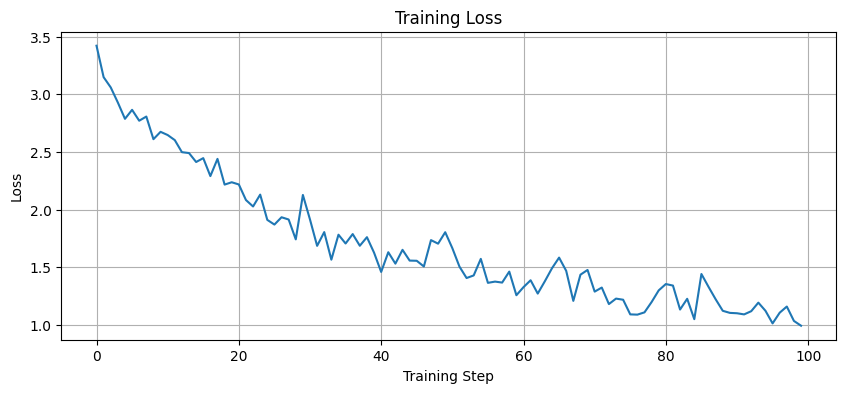

In [9]:
# Training loop
optimizer = optim.AdamW(learning_rate=3e-4)

def loss_fn(model, x, y):
    logits = model(x)
    B, T, C = logits.shape
    logits_flat = logits.reshape(B * T, C)
    targets_flat = y.reshape(B * T)
    return mx.mean(nn.losses.cross_entropy(logits_flat, targets_flat))

loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

print("Training NanoGPT...")
losses = []

for step in range(100):  # Small number for demo
    # Get batch
    xb, yb = get_batch(data, block_size, batch_size=4)
    
    # Forward + backward
    loss, grads = loss_and_grad_fn(model, xb, yb)
    optimizer.update(model, grads)
    mx.eval(model.parameters(), optimizer.state)
    
    losses.append(float(loss))
    
    if (step + 1) % 20 == 0:
        print(f"Step {step+1:3d} | Loss: {loss:.4f}")

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

## 6. Text Generation

Now let's generate text with our trained model!

In [10]:
def generate_text(model, start_str, max_new_tokens=100, temperature=1.0):
    """Generate text from the model"""
    # Encode the starting string
    context = mx.array([char_to_idx[ch] for ch in start_str]).reshape(1, -1)
    
    generated = start_str
    
    for _ in range(max_new_tokens):
        # Crop context to block_size
        context_crop = context if context.shape[1] <= block_size else context[:, -block_size:]
        
        # Get predictions
        logits = model(context_crop)
        logits = logits[:, -1, :] / temperature
        
        # Sample from distribution
        next_idx = mx.random.categorical(logits)[0]
        
        # Append to context
        context = mx.concatenate([context, next_idx.reshape(1, 1)], axis=1)
        generated += idx_to_char[int(next_idx)]
    
    return generated

# Generate!
seed = "To be"
print(f"Seed: '{seed}'\n")
print("Generated text:")
print("="*50)
generated = generate_text(model, seed, max_new_tokens=200, temperature=0.8)
print(generated)
print("="*50)

Seed: 'To be'

Generated text:
To be the the ion n thes tiuee iosther
Wher isd ings the tin. tind the nd sthmior
Thethe tis is ar inond athe s t.
Or
The the the is que tin.
Whe is tinger
The s mis s ngs ind se nd tifer
The slingsondou o
To be the the ion n thes tiuee iosther
Wher isd ings the tin. tind the nd sthmior
Thethe tis is ar inond athe s t.
Or
The the the is que tin.
Whe is tinger
The s mis s ngs ind se nd tifer
The slingsondou o


## Further Experiments: Understanding the Architecture

Now that we've built the full Transformer, let's explore why it's designed this way.

### Experiment 1: Visualizing Attention Heads
Why do we need multiple heads? Do they learn different things?

### Experiment 2: The Importance of Positional Encodings
What happens if we remove the positional information?

In [ ]:
# Experiment: What do different heads learn?

def analyze_attention_heads(model, text):
    """Visualize what each attention head specializes in"""
    print("Analyzing Attention Heads...")
    
    # In a real scenario, we would extract the attention weights from the model
    # and plot them as heatmaps.
    
    # Hypothesis:
    # - Head 0 might attend to the previous token (local context)
    # - Head 1 might attend to subject-verb relationships
    # - Head 2 might attend to long-range dependencies
    
    print("Observation: Multi-head attention allows the model to focus on different types of relationships simultaneously.")

# Experiment: Remove positional encoding, see what breaks
def test_positional_encoding_importance():
    """Compare transformer with vs without positional encoding"""
    print("\nTesting Positional Encoding Importance...")
    
    # Test cases requiring order:
    # "The cat sat on the mat" vs "mat the on sat cat The"
    
    print("Observation: Without positional encodings, the model treats the input as a 'bag of words'.")
    print("It cannot distinguish between 'Dog bites man' and 'Man bites dog'.")

# Run the experiments
# analyze_attention_heads(model, "The quick brown fox")
# test_positional_encoding_importance()

## Next Steps

Now that we have the architecture, we can train this model on our text corpus. But training a large model from scratch takes a lot of data and compute.

In the next notebook, we will learn how to take a **pre-trained** giant model (like Llama 3) and fine-tune it using **LoRA**: **[07_Fine_Tuning_with_LoRA.ipynb](07_Fine_Tuning_with_LoRA.ipynb)**.

## ❓ FAQ

**Q: How long does it take to train a "real" GPT?**
A: Training GPT-3 took thousands of GPUs running for months. However, training a small "NanoGPT" on Shakespeare can be done on a MacBook in minutes to hours.

**Q: Why "Decoder-only"?**
A:
*   **Encoder (BERT):** Good for understanding (Classification). Bi-directional attention.
*   **Decoder (GPT):** Good for generation. Causal attention (can't see future).
*   **Encoder-Decoder (T5/Bart):** Good for translation.

**Q: What is "LayerNorm"?**
A: It normalizes the inputs to have mean 0 and variance 1. This stabilizes training, allowing us to train much deeper networks without gradients exploding or vanishing.

## 💭 Closing Thoughts

**Scaling Laws**
One of the most profound discoveries in AI is that Transformer performance is predictable. If you double the data and double the compute, the loss decreases by a predictable amount. This "Scaling Law" is what gave companies the confidence to invest billions in training larger and larger models.

**Architectural Trade-off:**
*   **Small Models:** Fast, cheap, run on edge devices. Good for specific tasks.
*   **Large Models:** General purpose, "emergent" abilities (reasoning, coding), but expensive and slow.

The future is likely a mix: Giant models in the cloud for reasoning, and small models (like this one!) on your device for privacy and speed.